In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
global data_path, output_path
data_path = 'D:/ALSM/datas/'
output_path = "D:/ALSM/output"

Loading data...
Starting model run...
Saved model output toD:/ALSM/outputmodel_output.nc
Creating results plot...


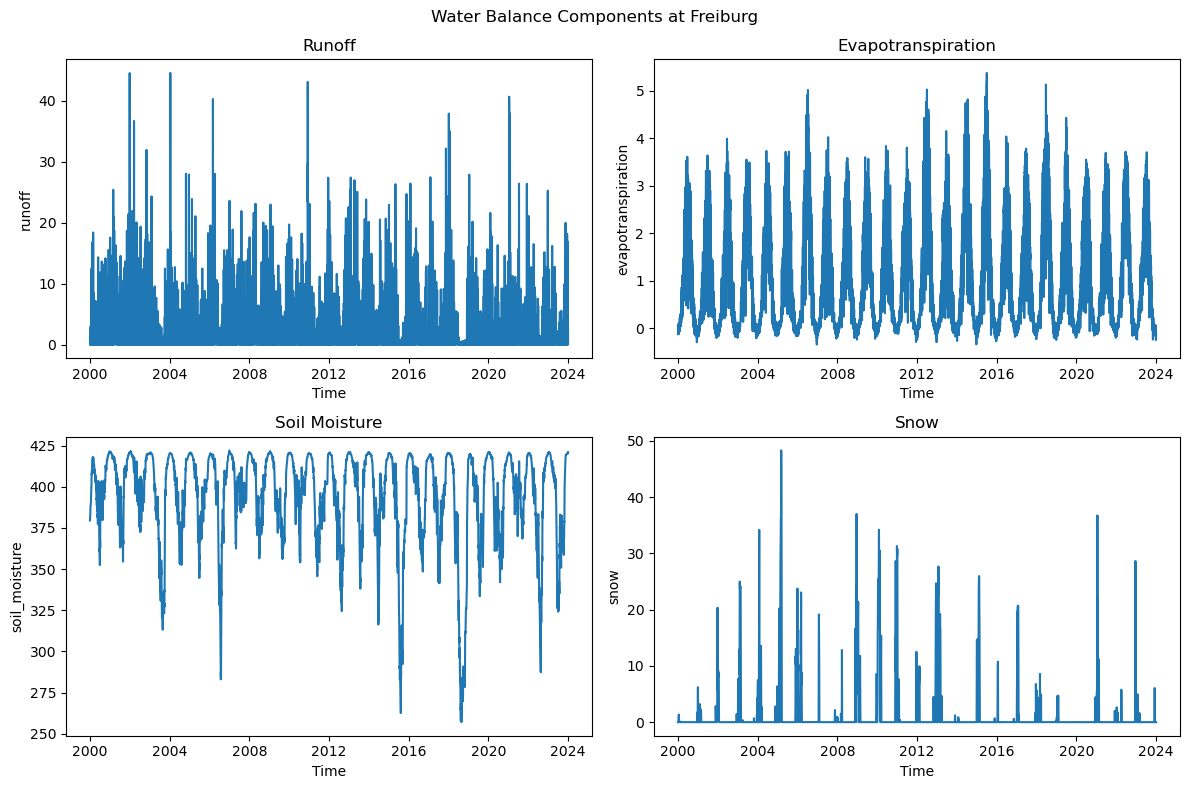

In [3]:
def calc_et_weight(temp, lai, w):
    """Calculate influence of LAI and temperature on ET.
    Input: temp: temperature data [K]
           lai: leaf area index data [m**2/m**2]
           w: weights for temperature and lai"""
    # Get coefficients for temperature and lai
    temp_w, lai_w = w
    lai = np.nan_to_num(lai, nan=0)
    temp_min = temp.min()
    temp_max = temp.max()
    lai_min = lai.min()
    lai_max = lai.max()

    # Perform normalization
    normalized_temp = (temp - temp_min) / (temp_max - temp_min)
    normalized_lai = (lai - lai_min) / (lai_max - lai_min)

    # Weight Temperature and LAI
    et_coef = temp_w * normalized_temp + lai_w * normalized_lai
    return et_coef

def water_balance(w_t, prec_t, rad_t, snow_t, temp_t, cs, alpha, beta, gamma, c_m):
    """ Calculates the water balance for one time step as introduced in the lecture. Added features, such as snow"""
    snow_t, prec_t = snow_function(snow_t, prec_t, temp_t,
                             c_m)  # overwrites the precipitation (if snow melts or precipitation is accumulated as snow)
    runoff_t = runoff(w_t, prec_t, cs, alpha)
    evapo_t = evapotranspiration(w_t, rad_t, cs, beta, gamma)
    w_next = w_t + (prec_t - evapo_t - runoff_t)
    w_next = np.maximum(0, w_next)
    
    return runoff_t, evapo_t, w_next, snow_t

def runoff(w_t, prec_t, cs, alpha):
    return prec_t * (w_t / cs) ** alpha

def evapotranspiration(w_t, rad_t, cs, beta, gamma):
    return beta * (w_t / cs) ** gamma * rad_t

def snow_function(snow_t, prec_t, temp_t, c_m):
    # Determine if temperature is above freezing (melting condition)
    is_melting = temp_t > 273.15
    
    # Determine if there is already snow on the ground
    has_snow = snow_t >= 0.001

    if not is_melting:
        # Temperature is below or at freezing → precipitation adds to snow
        snow_out = snow_t + prec_t
        water_out = 0.0
    elif is_melting and has_snow:
        # Snow is present and temperature is above freezing → melt snow
        SnowMelt = c_m * (temp_t - 273.15)
        snow_out = snow_t - SnowMelt
        if snow_out < 0:
            SnowMelt = snow_t  # Can't melt more than exists
            snow_out = 0.0
        water_out = SnowMelt + prec_t
    else:
        # No snow, and temperature above freezing → all precip is rain
        snow_out = snow_t
        water_out = prec_t

    return snow_out, water_out

def time_evolution(temp, rad, prec, lai, params):
    runoff_out = np.full_like(temp, np.nan)
    evapo_out = np.full_like(temp, np.nan)
    soil_mois_out = np.full_like(temp, np.nan)
    snow_out = np.full_like(temp, np.nan)
    
    if np.all(np.isnan(lai)):
        #edge case for no vegetation
        return runoff_out, evapo_out, soil_mois_out, snow_out
    cs, alpha, gamma, beta, c_m, et_weight = params
    #conversion factor

    conv = 1 / 2260000  # from J/day/m**2 to mm/day
    rad = rad * conv  # convert radiation to mm/day
    prec = prec * 10 **3 # from m/day to mm/day
    
    w_0 = 0.9 * cs
    snow_0 = 0
    
    beta_weighted = beta * calc_et_weight(temp, lai, et_weight)
    
    for t in range(1, len(temp)):
        prec_t = prec[t-1]
        temp_t = temp[t-1]
        rad_t = rad[t-1]
        beta_weighted_t = beta_weighted[t-1]
        runoff_out[t], evapo_out[t], soil_mois_out[t], snow_out[t] = water_balance(
            w_0, prec_t, rad_t, snow_0, temp_t, cs, alpha, beta_weighted_t, gamma, c_m)
        w_0 = soil_mois_out[t]
        snow_0 = snow_out[t]
        
    return runoff_out, evapo_out, soil_mois_out, snow_out

def load_data():
    print('Loading data...')
    temperature = xr.open_mfdataset(data_path + 'daily_average_temperature/*.nc', combine='by_coords').load()
    precipitation = xr.open_mfdataset(data_path + 'total_precipitation/*.nc', combine='by_coords').load()
    radiation = xr.open_mfdataset( data_path + 'net_radiation/*.nc', combine='by_coords').load()
    lai = xr.open_mfdataset(data_path + 'lai_full/*.nc', combine='by_coords').load()
    global data 
    data = xr.Dataset()
    data['temperature'] = temperature['t2m']
    data['precipitation'] = precipitation['tp']
    data['radiation'] = radiation['nr']
    data['lai'] = lai['lai']

    #get rid of anythin before 2002 and after 2018
    data = data.sel(time=slice('2000-01-01', '2023-12-31'))
def main():

    params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]     # cs, alpha, gamma, beta, c_m, et_weight
    
    # Load data
    load_data()
    print('Starting model run...')
    runoff, evapo, soil_mois, snow = xr.apply_ufunc(
    time_evolution,
    data['temperature'],
    data['radiation'],
    data['precipitation'],
    data['lai'],
    kwargs={'params': params},
    input_core_dims=[['time'], ['time'], ['time'], ['time']],
    output_core_dims=[['time'], ['time'], ['time'], ['time']],
    vectorize=True,
    dask='allowed',
    output_dtypes=[np.float64, np.float64, np.float64, np.float64])

    results = xr.Dataset({
        'runoff': runoff,
        'evapotranspiration': evapo,
        'soil_moisture': soil_mois,
        'snow': snow
    })
    
    #write this into a netcdf file
    #create output folder

    os.makedirs(output_path, exist_ok=True)
    #save the dataset
    results.to_netcdf(output_path+'model_output.nc')
    print('Saved model output to' + output_path+'model_output.nc')
    create_results_plot(results)
    
def create_results_plot(res):
    print('Creating results plot...')
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    res_freiburg = res.sel(lat=47.999, lon=7.845, method='nearest')
    res_freiburg['runoff'].plot(ax=axs[0, 0], label='Runoff')
    res_freiburg['evapotranspiration'].plot(ax=axs[0, 1], label='Evapotranspiration')
    res_freiburg['soil_moisture'].plot(ax=axs[1, 0], label='Soil Moisture')
    res_freiburg['snow'].plot(ax=axs[1, 1], label='Snow')
    axs[0, 0].set_title('Runoff')
    axs[0, 1].set_title('Evapotranspiration')
    axs[1, 0].set_title('Soil Moisture')
    axs[1, 1].set_title('Snow')
    for ax in axs.flat:
        ax.set_xlabel('Time')
    plt.suptitle('Water Balance Components at Freiburg')
    plt.tight_layout()
    plt.savefig(output_path+'water_balance_components.png')

if __name__ == "__main__":
    main()

